# $fO_2$ buffer demonstration
In this notebook, I model the control that an $fO_2$ buffer pair exerts on the $fO_2$ of a chemical system. 

## 1. Import Libraries

In [1]:
import thermofun as fun
import reaktoro as rkt
import numpy as np
import matplotlib.pyplot as plt

## 2. Initialize a thermodynamic database

In [3]:
database = fun.Database('./databases/Willy_ThermoHub_db.json')
#database = fun.Database('./databases/ThermoFun_db/mines16-thermofun.json')
#database.appendData('./databases/ThermoFun_db/mines16-thermofun.json')
database.appendData('./databases/elements.json') # append element data & data for H2O(l), OH-, and H+ to database
database.appendData('./databases/fO2_buffers.json')

### 2a. Check the contents of the database (optional)

In [4]:
substances = database.mapSubstances()
#print(substances.keys())

## 3. Define and construct the chemical system

In [5]:
# Define the chemical system
editor = rkt.ChemicalEditor(database)
editor.addMineralPhase([
    'Hematite', 'Magnetite']) # symbol (not name) in database
editor.addGaseousPhase([
    'O2,rg'])
# Construct the chemical system
system = rkt.ChemicalSystem(editor)

## 4. Define and solve the equilibrium problem

In [6]:
options = rkt.EquilibriumOptions()
options.optimum.output.active = True
options.epsilon = 1e-50

In [7]:
O2_mol_amounts = np.logspace(-10,-2.5,100)
amount = np.zeros((3,100))
for i,O2_mol_amount in enumerate(O2_mol_amounts): 
    # define and solve O2 buffer equilibrium
    problem = rkt.EquilibriumProblem(system)
    
    problem.add("Magnetite",10**0,"g") 
    problem.add("Hematite",10**0,"g") 
    problem.add("O2,rg",O2_mol_amount,"mol")
    
    problem.setPressure(1,"bar")
    problem.setTemperature(500,"kelvin")
    
    solver = rkt.EquilibriumSolver(system)
    state = rkt.ChemicalState(system)
    solver.setOptions(options)
    solver.solve(state, problem)    

    amount[0,i] = state.speciesAmount("O2,rg")#/buffer_system.species()[0].molarMass()
    amount[1,i] = state.speciesAmount("Hematite")#/buffer_system.species()[1].molarMass()
    amount[2,i] = state.speciesAmount("Magnetite")#/buffer_system.species()[2].molarMass()

## 5. Plot the results

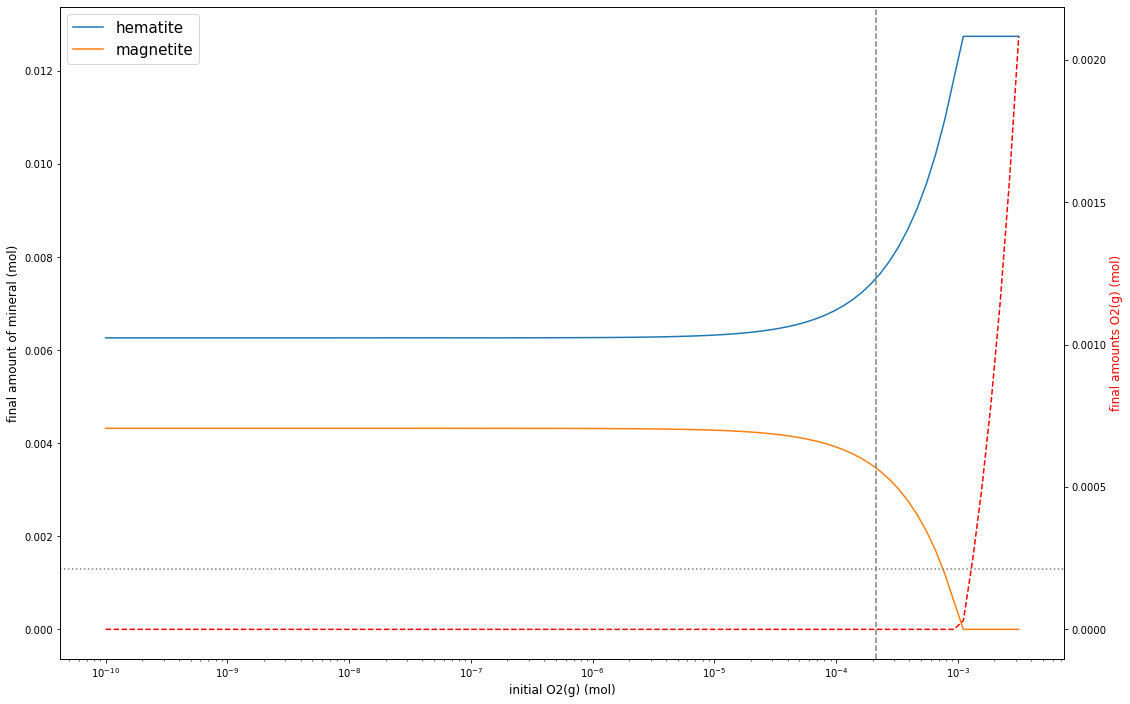

In [18]:
fig, ax1 = plt.subplots(figsize=[18,12])
ax1.semilogx(O2_mol_amounts, amount[1,])
ax1.semilogx(O2_mol_amounts, amount[2,])
ax1.axvline(x=1*5.2375E-3/(8.314E-2*298.15),color='grey',linestyle='--')
ax1.legend(['hematite','magnetite'],fontsize=15)
ax2 = ax1.twinx()
ax1.set_xlabel('initial O2(g) (mol)',fontsize=12)
ax1.set_ylabel('final amount of mineral (mol)',fontsize=12)

ax2.semilogx(O2_mol_amounts, amount[0,],color='red',linestyle='--')
ax2.axhline(y=1*5.2375E-3/(8.314E-2*298.15),color='grey',linestyle=':')
ax2.set_ylabel('final amounts O2(g) (mol)',color='red',fontsize=12)

plt.show()
# print(amount[0,])